In [4]:
# !pip install alpaca-trade-api
# !pip install requests
# !pip install pandas
# !pip install nltk
# !pip install textblob
# !pip install matplotlib
# !pip install vaderSentiment
# !pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 774.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Successfully uninstalled msgpack-1.0.8
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.2
    Uninstalling PyYAML-6.0.2:
      Successfully uninstalled PyYAML-6.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.0 MB/s eta 0:00:00


## **Import Necessary Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import time
import asyncio
from tabulate import tabulate

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Initialize Alpaca API**

In [6]:
# Replace with your actual API and secret key
API_KEY = ''
SECRET_KEY = ''
BASE_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')
SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']



## **Data Collection**

In [7]:
def collect_data(symbol, start_date, end_date):
    timeframe = '1Day'  # Daily data
    bars = api.get_bars(symbol, timeframe, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d')).df
    bars = bars.sort_index()
    return bars


start_date = datetime.now() - timedelta(days=365)
end_date = datetime.now() - timedelta(days=1)
# for symbol in SYMBOLS:
#   print(f"Collecting data for {symbol}...")
#   bars = collect_data(symbol, start_date, end_date)
#   bars.rename(columns={'timestamp': 'created_at'})
#   print(tabulate(bars.head(), headers='keys', tablefmt='pretty'))


In [9]:

# # Initialize the streaming connection
# conn = tradeapi.Stream(API_KEY, SECRET_KEY, BASE_URL)

# # Define a handler for receiving live data
# async def on_bar(bar):
#     print(f"Received bar data: {bar}")

# # Subscribe to real-time bars for a specific symbol
# conn.subscribe_bars(on_bar, symbol)

# # Use asyncio.create_task() to schedule the coroutine instead of asyncio.run()
# async def run_stream():
#     await conn.run()

# loop = asyncio.get_event_loop()
# task = loop.create_task(run_stream())
# # print(bar)


## **Sentiment Analysis**



In [10]:
def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in nltk.corpus.stopwords.words('english')]
    return ' '.join(words)

def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Polarity ranges from -1 to 1

def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Compound score ranges from -1 to 1

def fetch_news_and_analyze_sentiment(symbol, start_date, end_date):
    news = api.get_news(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    news_df = pd.DataFrame([{
        'headline': item.headline,
        'summary': item.summary,
        'source': item.source,
        'created_at': item.created_at
    } for item in news])

    news_df['cleaned_headline'] = news_df['headline'].apply(preprocess_text)
    news_df['cleaned_summary'] = news_df['summary'].apply(preprocess_text)
    news_df['sentiment_headline_textblob'] = news_df['cleaned_headline'].apply(analyze_sentiment_textblob)
    news_df['sentiment_summary_textblob'] = news_df['cleaned_summary'].apply(analyze_sentiment_textblob)
    news_df['sentiment_headline_vader'] = news_df['cleaned_headline'].apply(analyze_sentiment_vader)
    news_df['sentiment_summary_vader'] = news_df['cleaned_summary'].apply(analyze_sentiment_vader)
    news_df['combined_sentiment_textblob'] = (news_df['sentiment_headline_textblob'] + news_df['sentiment_summary_textblob']) / 2
    news_df['combined_sentiment_vader'] = (news_df['sentiment_headline_vader'] + news_df['sentiment_summary_vader']) / 2

    return news_df.set_index('created_at')
    # return news_df

start_date = datetime.now() - timedelta(days=1825)
end_date = datetime.now() - timedelta(days=1)

for symbol in SYMBOLS:
  print(f"Analyzing sentiment for {symbol}...")
  news_df = fetch_news_and_analyze_sentiment(symbol, start_date, end_date)
  # news_df.rename(columns={'created_at': 'timestamp'})
  print(tabulate(news_df, headers='keys', tablefmt='pretty'))
  print(news_df.shape)

Analyzing sentiment for AAPL...
+---------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+----------------------------+--------------------------+-------------------------+-----------------------------+--------------------------+
|        created_at         |                 

## **Sentiment Analysis Visualization**

Visualizing sentiment for AAPL...


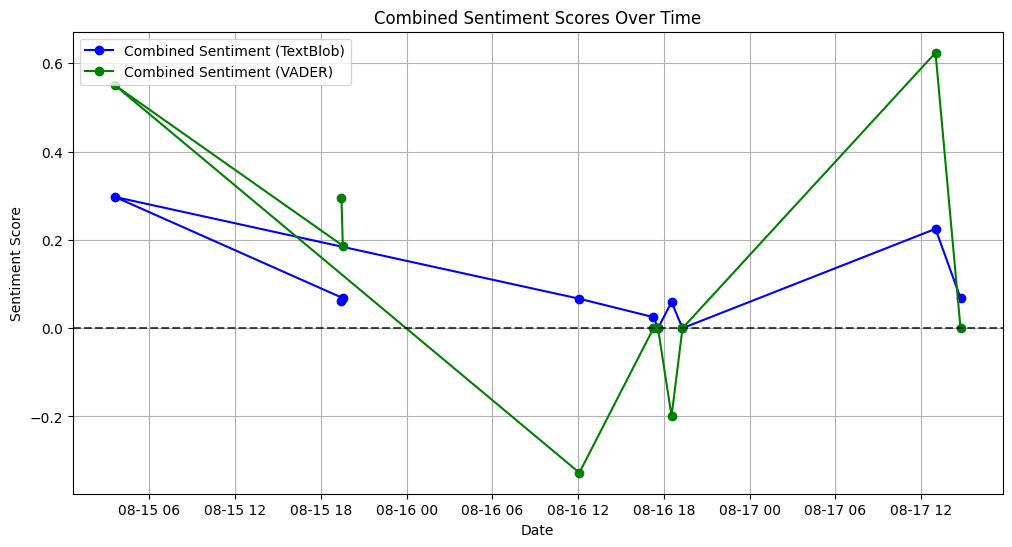

Visualizing sentiment for MSFT...


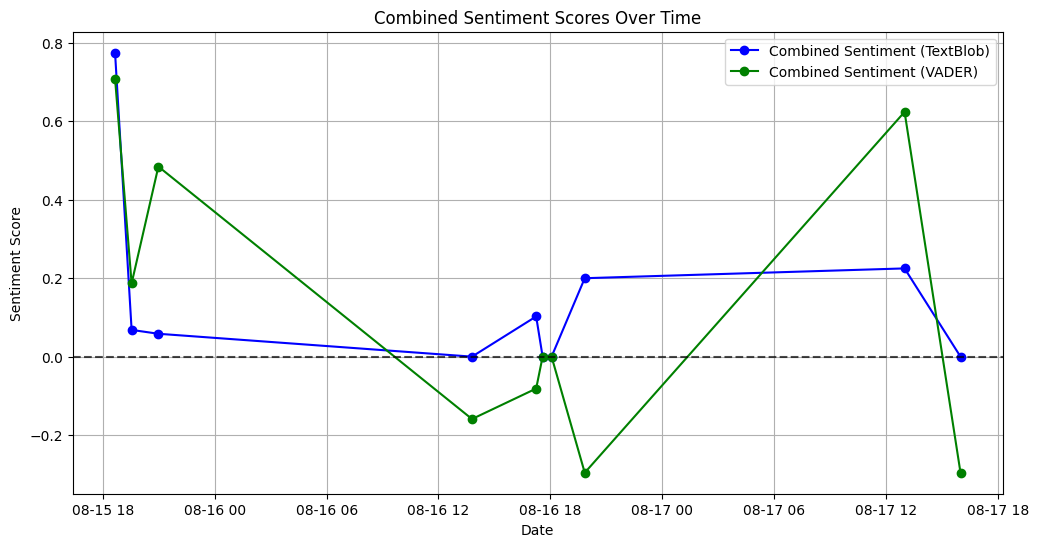

Visualizing sentiment for GOOGL...


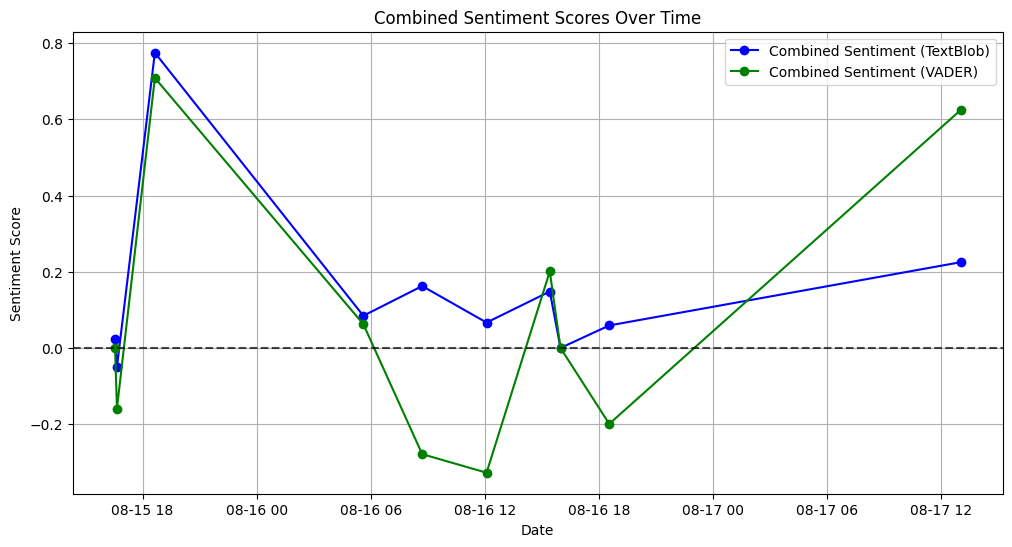

Visualizing sentiment for AMZN...


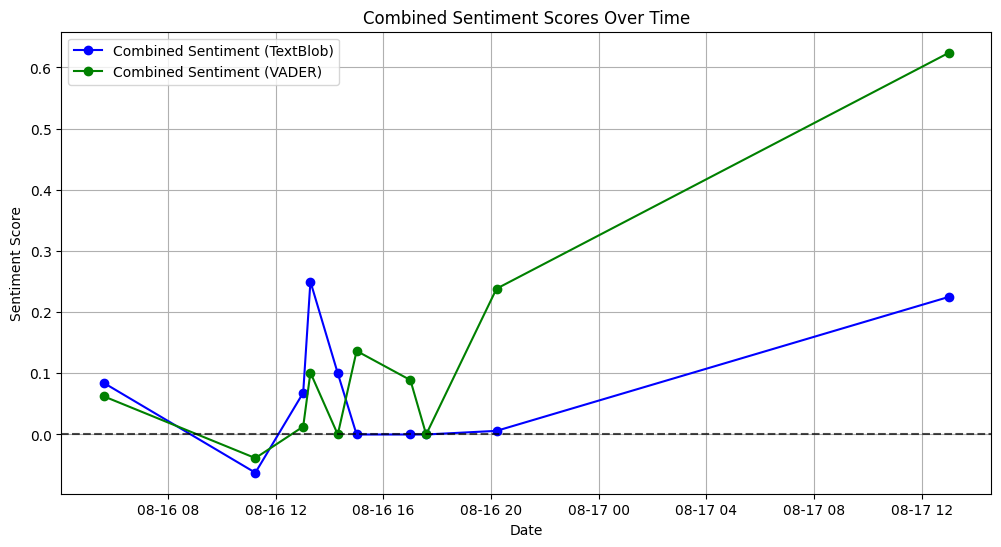

Visualizing sentiment for TSLA...


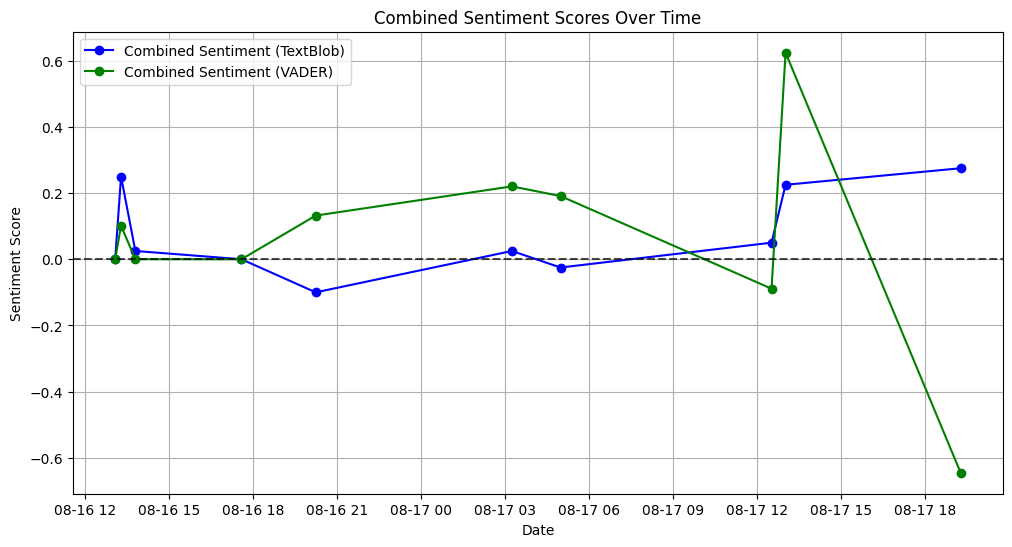

In [11]:
def visualize_sentiment(news_df, symbol):
    # Plot combined sentiment scores from TextBlob and VADER
    plt.figure(figsize=(12, 6))

    # Plot combined sentiment scores from TextBlob
    plt.plot(news_df.index, news_df['combined_sentiment_textblob'], label='Combined Sentiment (TextBlob)', color='blue', marker='o')

    # Plot combined sentiment scores from VADER
    plt.plot(news_df.index, news_df['combined_sentiment_vader'], label='Combined Sentiment (VADER)', color='green', marker='o')

    # Add labels and title
    plt.title('Combined Sentiment Scores Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)  # Add a horizontal line at 0 for neutral sentiment
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


for symbol in SYMBOLS:
  print(f"Visualizing sentiment for {symbol}...")
  news_df = fetch_news_and_analyze_sentiment(symbol, start_date, end_date)
  visualize_sentiment(news_df, symbol)

## **Technical Analysis**

In [12]:
def calculate_rsi(data, window):
    delta = data.diff(1)  # Calculate the change in price
    gain = delta.where(delta > 0, 0)  # Keep only the positive changes (gains)
    loss = -delta.where(delta < 0, 0)  # Keep only the negative changes (losses)

    # Check if data has enough variability
    if gain.mean() == 0 and loss.mean() == 0:
        print("Warning: Data has no variability.")
        return pd.Series(np.zeros(len(data)), index=data.index)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


## **Technical Analysis Visualization**

In [13]:

# bars['SMA_50'] = bars['close'].rolling(window=50).mean()
# bars['RSI_14'] = calculate_rsi(bars['close'], 14)
# bars['EMA_12'] = bars['close'].ewm(span=12, adjust=False).mean()
# bars['EMA_26'] = bars['close'].ewm(span=26, adjust=False).mean()
# bars['MACD'] = bars['EMA_12'] - bars['EMA_26']
# bars['Signal_Line'] = bars['MACD'].ewm(span=9, adjust=False).mean()

def calculate_technical_indicators_and_visualize(bars, symbol):
    # Calculate indicators
    bars['SMA_50'] = bars['close'].rolling(window=50).mean()
    bars['RSI_14'] = calculate_rsi(bars['close'], 14)
    bars['EMA_12'] = bars['close'].ewm(span=12, adjust=False).mean()
    bars['EMA_26'] = bars['close'].ewm(span=26, adjust=False).mean()
    bars['MACD'] = bars['EMA_12'] - bars['EMA_26']
    bars['Signal_Line'] = bars['MACD'].ewm(span=9, adjust=False).mean()

    if bars['RSI_14'].mean() == 0:
        print("Warning: RSI is flat, possibly due to constant data.")
    else:
        # Plot closing price and SMA
        plt.figure(figsize=(14, 7))
        plt.plot(bars.index, bars['close'], label='Close Price', color='blue')
        plt.plot(bars.index, bars['SMA_50'], label='50-Day SMA', color='orange')
        plt.title(f'{symbol} Close Price and 50-Day SMA')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # Plot RSI
        plt.figure(figsize=(14, 5))
        plt.plot(bars.index, bars['RSI_14'], label='14-Day RSI', color='purple')
        plt.axhline(70, linestyle='--', alpha=0.5, color='red')
        plt.axhline(30, linestyle='--', alpha=0.5, color='green')
        plt.title(f'{symbol} 14-Day RSI')
        plt.xlabel('Date')
        plt.ylabel('RSI')
        plt.legend()
        plt.show()

    # Plot MACD and Signal Line
    plt.figure(figsize=(14, 5))
    plt.plot(bars.index, bars['MACD'], label='MACD', color='blue')
    plt.plot(bars.index, bars['Signal_Line'], label='Signal Line', color='red')
    plt.title(f'{symbol} MACD and Signal Line')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.show()

    return bars

# for symbol in SYMBOLS:
#   print(f"Calculating and visualizing technical indicators for {symbol}...")
#   # bars = collect_data(symbol, start_date, end_date)
#   bars = calculate_technical_indicators_and_visualize(bars, symbol)


## **Merge Data and Generate Signals**

In [52]:
# def merge_data_and_generate_signals(bars, news_df):
#     bars_with_sentiment = bars.copy()
#     bars_with_sentiment['combined_sentiment'] = news_df['combined_sentiment_vader'].resample('D').mean()
#     bars_with_sentiment['combined_sentiment'].fillna(method='ffill', inplace=True)

#     bars_with_sentiment['Refined_Signal'] = 0  # Neutral signal by default

#     buy_condition = (
#         (bars_with_sentiment['close'] > bars_with_sentiment['SMA_50']) &
#         (bars_with_sentiment['RSI_14'] < 30) &
#         (bars_with_sentiment['MACD'] > bars_with_sentiment['Signal_Line']) &
#         (bars_with_sentiment['combined_sentiment'] > 0)
#     )
#     bars_with_sentiment['Refined_Signal'][buy_condition] = 1  # Buy signal

#     sell_condition = (
#         (bars_with_sentiment['close'] < bars_with_sentiment['SMA_50']) &
#         (bars_with_sentiment['RSI_14'] > 70) &
#         (bars_with_sentiment['MACD'] < bars_with_sentiment['Signal_Line']) &
#         (bars_with_sentiment['combined_sentiment'] < 0)
#     )
#     bars_with_sentiment['Refined_Signal'][sell_condition] = -1  # Sell signal

#     return bars_with_sentiment

# bars_with_sentiment = merge_data_and_generate_signals(bars, news_df)
# print(tabulate(bars_with_sentiment.head(), headers='keys', tablefmt='pretty'))

In [14]:
def generate_signals(bars):
    # Initialize the signal column
    bars['signal'] = 0

    # Buy Signal
    buy_condition = (bars['RSI_14'] < 30) & (bars['MACD'] > bars['Signal_Line'])
    bars.loc[buy_condition, 'signal'] = 1

    # Sell Signal
    sell_condition = (bars['RSI_14'] > 70) & (bars['MACD'] < bars['Signal_Line'])
    bars.loc[sell_condition, 'signal'] = -1

    return bars


# # Generate signals
# bars_with_signals = generate_signals(bars)

# # Display the last few rows with signals
# bars_with_signals.tail()


## **Backtesting**

In [15]:
def backtest_strategy(bars_with_signals, initial_capital=10000):
    capital = initial_capital
    position = 0
    portfolio = []
    returns = []

    for i in range(1, len(bars_with_signals)):
        signal = bars_with_signals['signal'].iloc[i]
        price = bars_with_signals['close'].iloc[i]

        if signal == 1 and position == 0:
            position = capital / price
            capital = 0
            portfolio.append(position * price)
            print(f"Buy: {bars_with_signals.index[i]}, Price: {price:.2f}")

        elif signal == -1 and position > 0:
            capital = position * price
            returns.append((capital - initial_capital) / initial_capital)
            portfolio.append(capital)
            position = 0
            print(f"Sell: {bars_with_signals.index[i]}, Price: {price:.2f}")

    if position > 0:
        capital = position * bars_with_signals['close'].iloc[-1]
        returns.append((capital - initial_capital) / initial_capital)
        portfolio.append(capital)
        position = 0
        print(f"Sell (End of Period): {bars_with_signals.index[-1]}, Price: {bars_with_signals['close'].iloc[-1]:.2f}")

    total_return = (capital - initial_capital) / initial_capital
    returns = np.array(returns)
    annualized_return = np.mean(returns) * 252
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
    max_drawdown = np.min(returns)

    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    return bars_with_signals, total_return

# Backtest the strategy
# bars_with_signals, total_return = backtest_strategy(bars)


In [16]:
def backtest_strategy(bars_with_sentiment, initial_capital=100000, risk_per_trade=0.02):
    position = 0
    capital = initial_capital
    portfolio_value = []

    for i in range(len(bars_with_sentiment)):
        latest_data = bars_with_sentiment.iloc[i]

        if latest_data['signal'] == 1 and position == 0:  # Buy signal
            position_size = capital * risk_per_trade // latest_data['close']
            capital -= position_size * latest_data['close']
            position += position_size

        elif latest_data['signal'] == -1 and position > 0:  # Sell signal
            capital += position * latest_data['close']
            position = 0

        portfolio_value.append(capital + position * latest_data['close'])

    bars_with_sentiment['Portfolio_Value'] = portfolio_value
    total_return = (bars_with_sentiment['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
    return bars_with_sentiment, total_return

# backtest_strategy(bars)

## **Trading Strategy Implementation with Alpaca**

In [17]:
# Calculate position size based on trade capital
def calculate_position_size(trade_capital, price):
    return trade_capital // price

# Place stop-loss order
def place_stop_loss_order(symbol, qty, entry_price, stop_loss_percentage=0.02):
    stop_price = entry_price * (1 - stop_loss_percentage)
    try:
        stop_loss_order = api.submit_order(
            symbol=symbol,
            qty=qty,
            side='sell',
            type='stop',
            stop_price=stop_price,
            time_in_force='gtc'  # Good till canceled
        )
        print(f"Stop-loss order placed for {symbol} at {stop_price:.2f}")
    except Exception as e:
        print(f"Failed to place stop-loss order: {e}")


In [20]:
def execute_trade(symbol, bars_with_sentiment, alpaca_api, trade_capital=10000, stop_loss_percentage=0.02):
    # Set up Alpaca API (Ensure to replace 'Your-API-Key' and 'Your-Secret-Key' with actual keys)
    api = tradeapi.REST(API_KEY, SECRET_KEY, base_url='https://paper-api.alpaca.markets')
    # trade_capital = float(api.get_account().cash ) # Get available buying power
    position = None  # Track current position

    for i in range(1, len(bars_with_sentiment)):
        signal = bars_with_sentiment['signal'].iloc[i]
        price = bars_with_sentiment['close'].iloc[i]

        if signal == 1 and position is None:  # Buy signal
            qty = calculate_position_size(trade_capital, price)
            qty = int(qty)
             # Calculate quantity based on trade capital

             # Ensure qty is at least 1
            if qty < 1:
                print(f"Insufficient capital to buy any shares of {symbol}. Skipping trade.")
                continue

            api.submit_order(
                symbol=symbol,
                qty=qty,
                side='buy',
                type='market',
                time_in_force='gtc'
            )
            place_stop_loss_order(symbol, qty, price, stop_loss_percentage)
            position = qty
            print(f"Bought {qty} shares of {symbol} at {price:.2f}")

            time.sleep(60)  # Wait for 1 min before next trade

        elif signal == -1 and position is not None:  # Sell signal
            api.submit_order(
                symbol=symbol,
                qty=position,
                side='sell',
                type='market',
                time_in_force='gtc'
            )
            print(f"Sold {position} shares of {symbol} at {price:.2f}")
            position = None  # Reset position
            time.sleep(60)  # Wait for 1 min before next trade
            break  # Stop after a single trade

    print("Trading completed.")


# # Example usage with trading execution
# symbols = ['AAPL', 'MSFT', 'GOOG']
# execute_trade('AAPL', bars_with_signals, api)


## **Run the Strategy for Multiple Symbols**


Running strategy for AAPL...



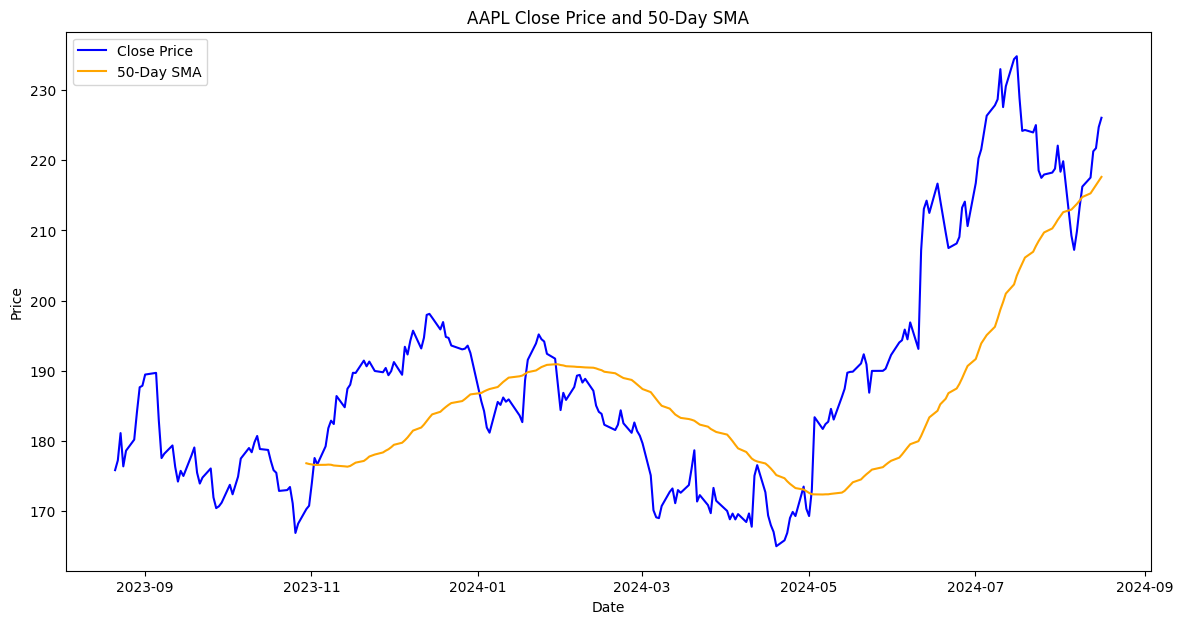

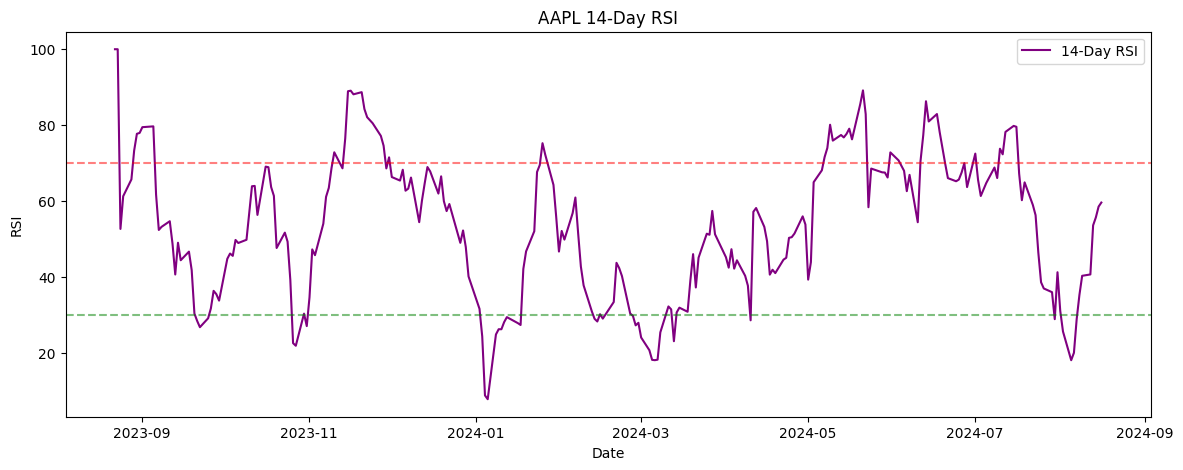

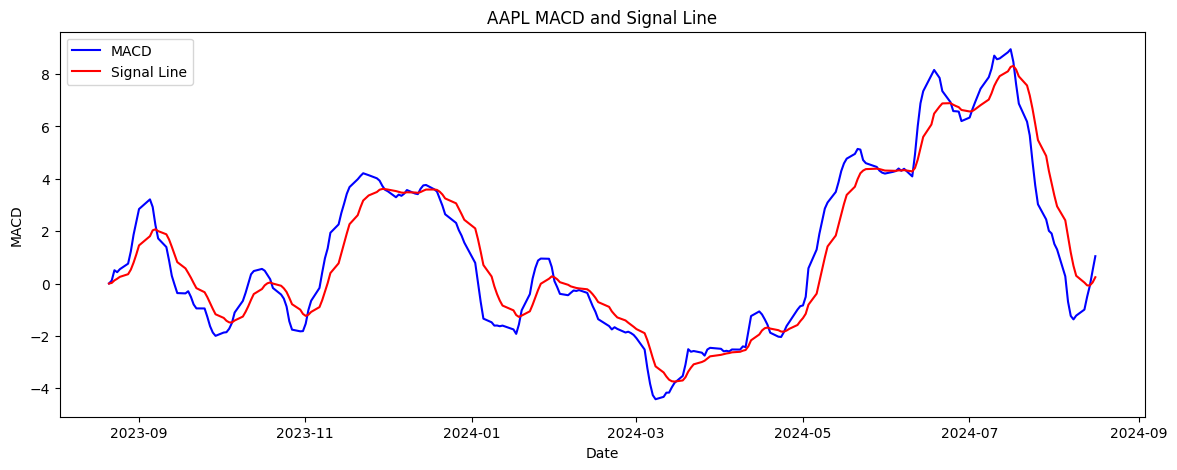

Total Return for AAPL: 0.27%
Failed to place stop-loss order: invalid stop_price 164.4244. sub-penny increment does not fulfill minimum pricing criteria
Bought 59.0 shares of AAPL at 167.78
Sold 59.0 shares of AAPL at 192.25
Trading completed.

Running strategy for MSFT...



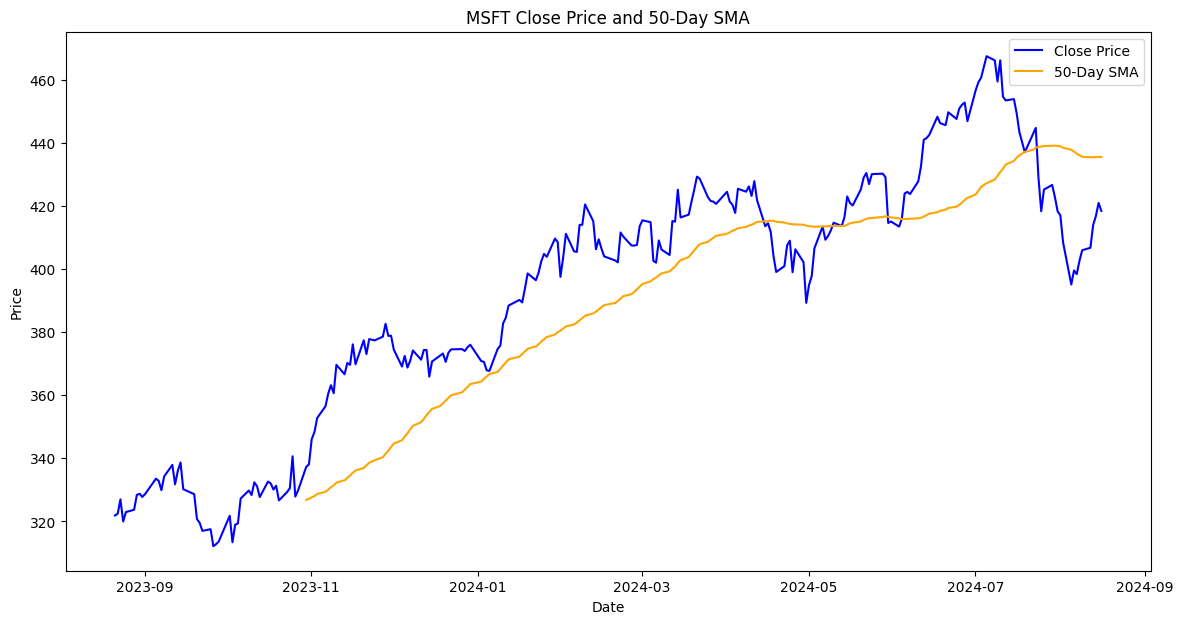

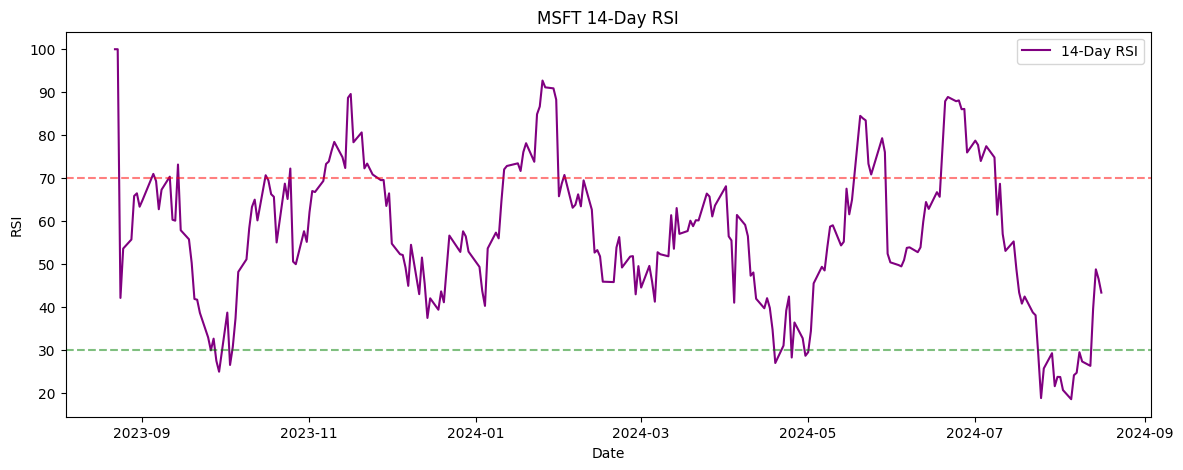

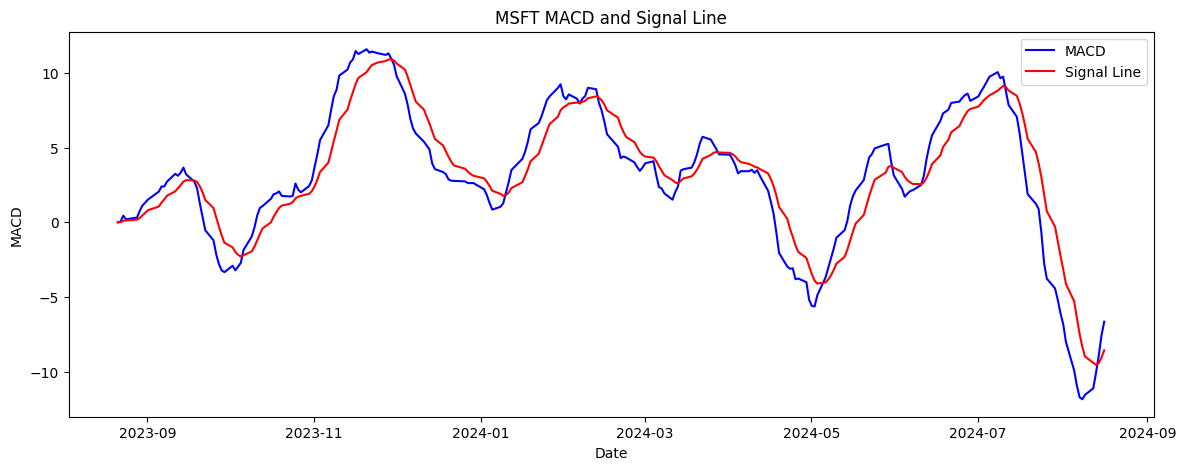

Total Return for MSFT: 0.00%
Trading completed.

Running strategy for GOOGL...



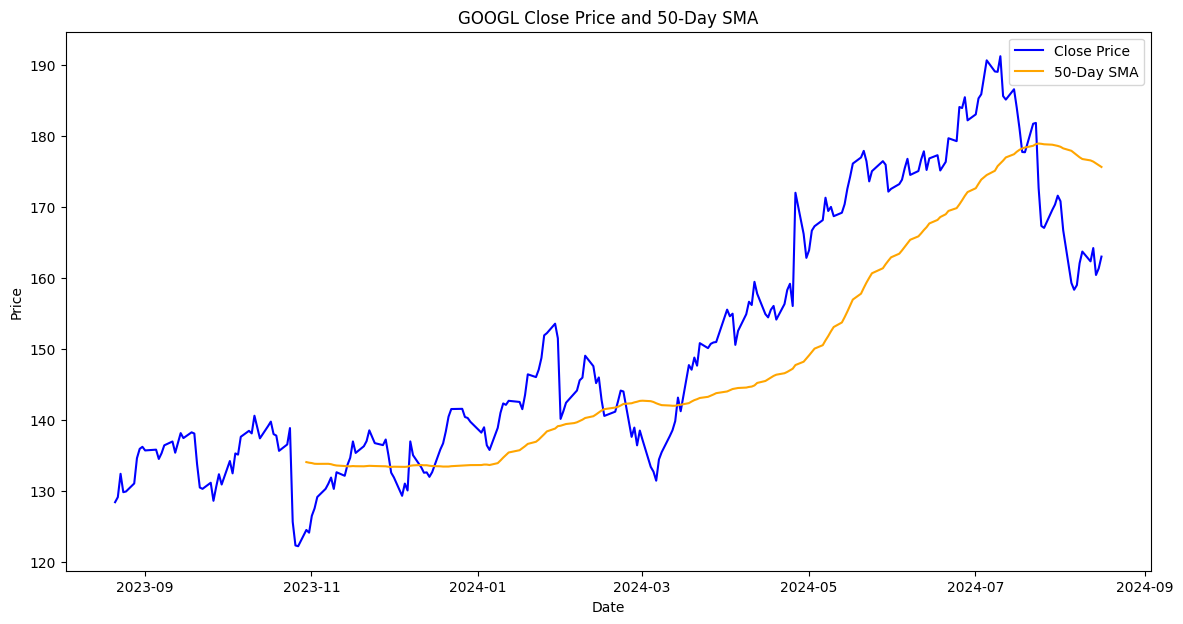

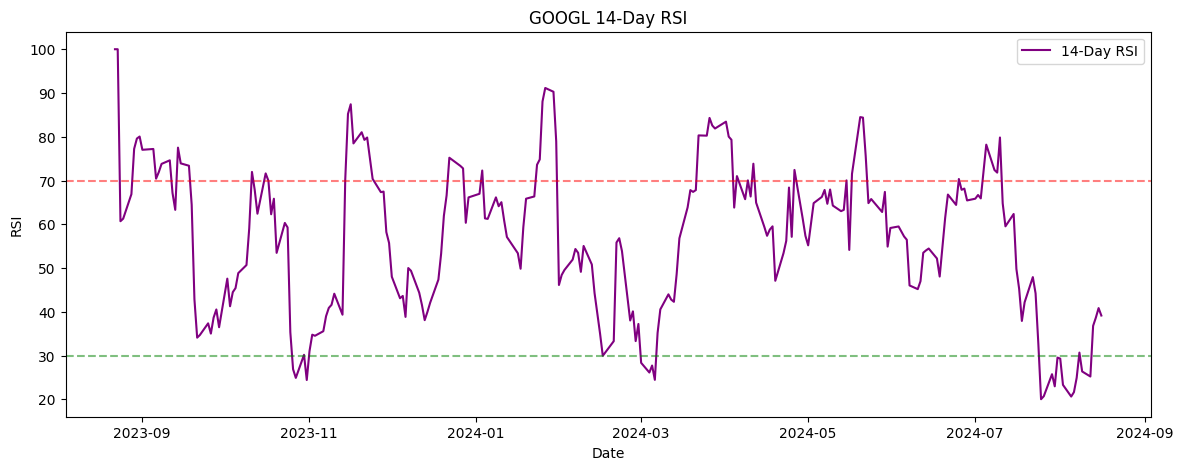

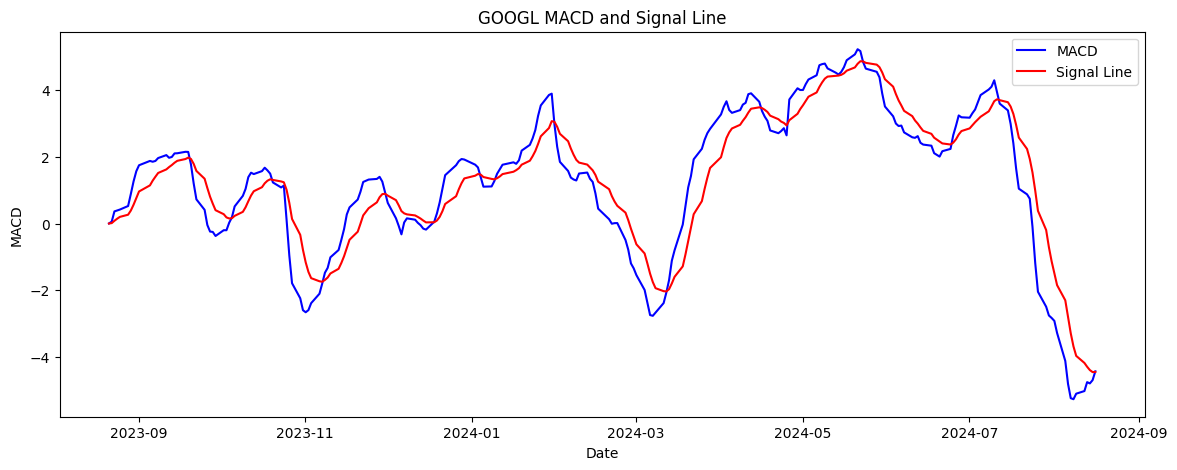

Total Return for GOOGL: 0.00%
Trading completed.

Running strategy for AMZN...



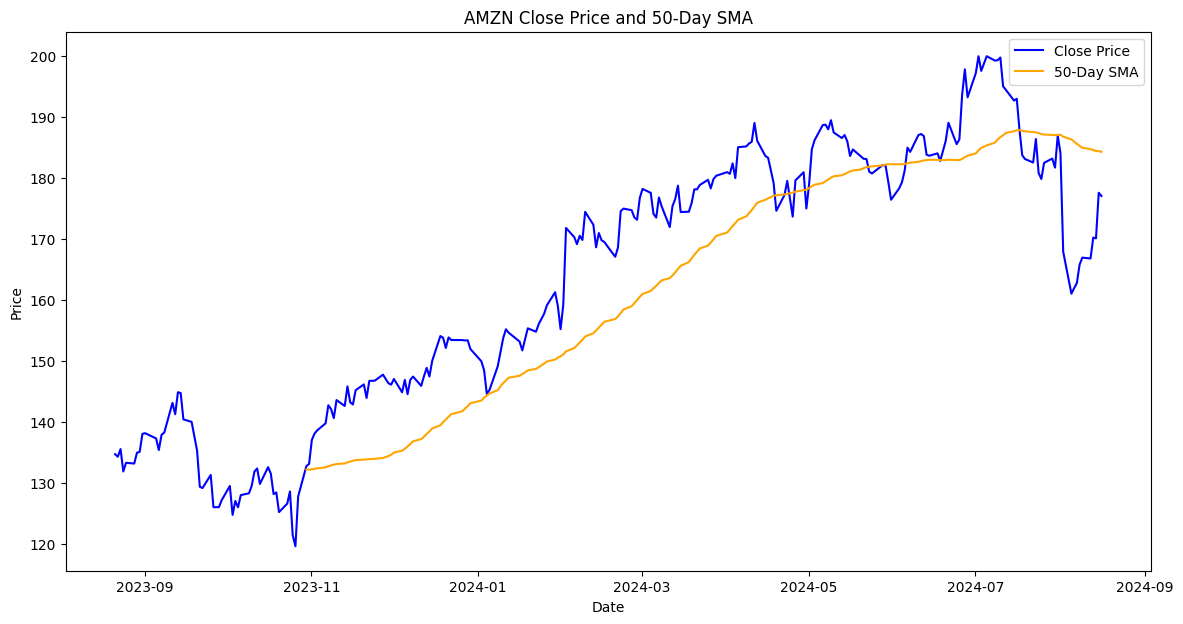

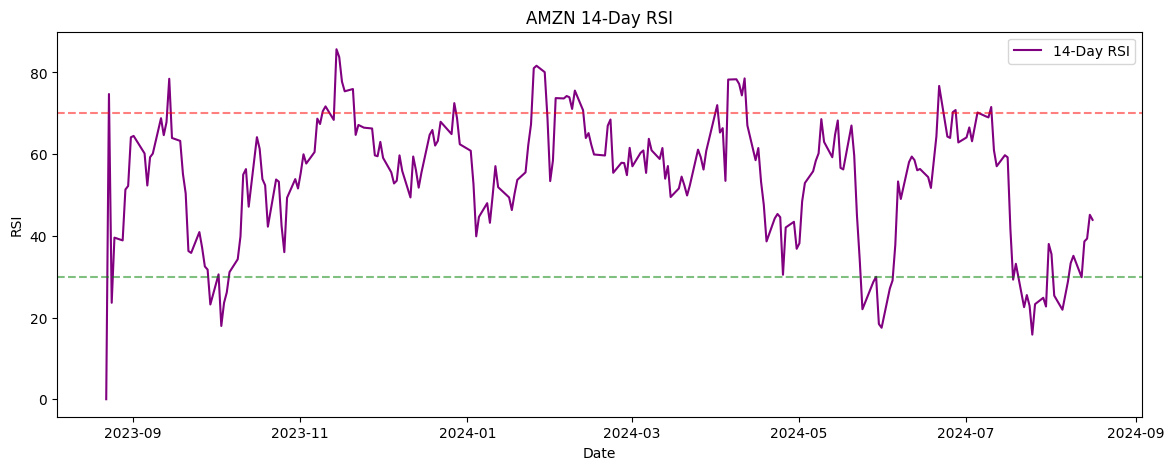

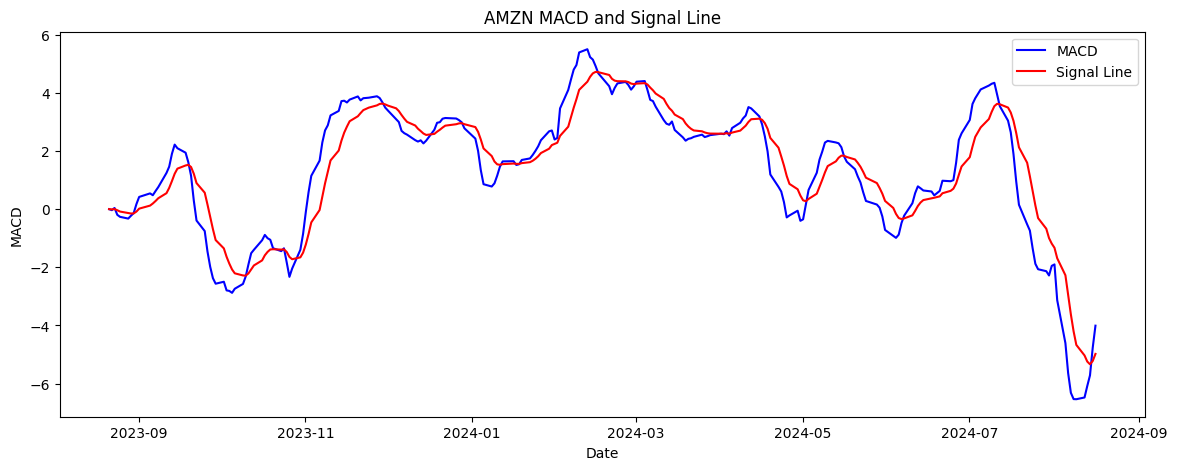

Total Return for AMZN: 0.00%
Trading completed.

Running strategy for TSLA...



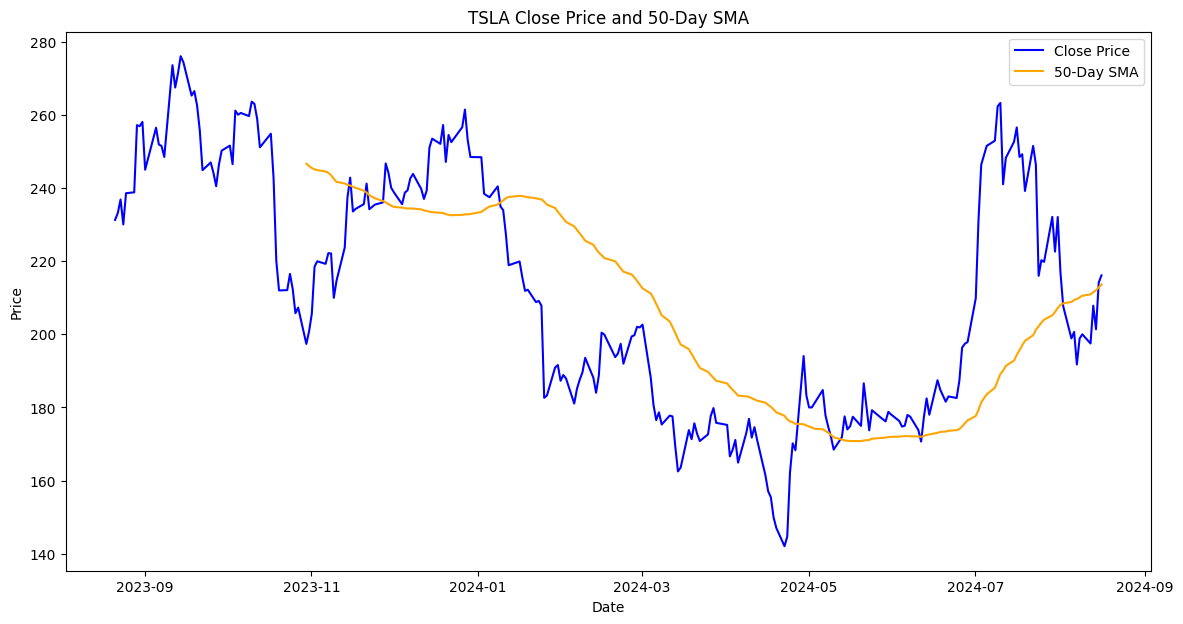

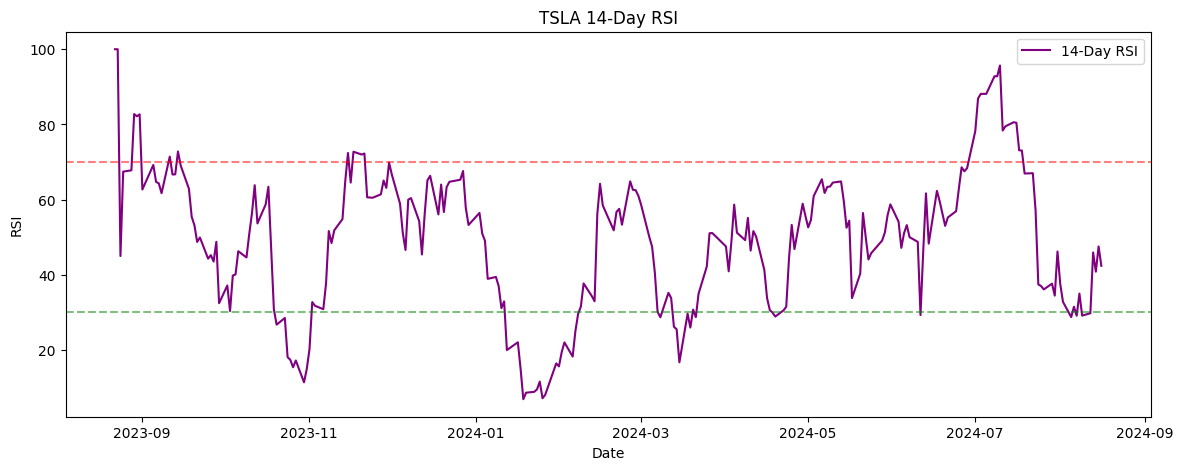

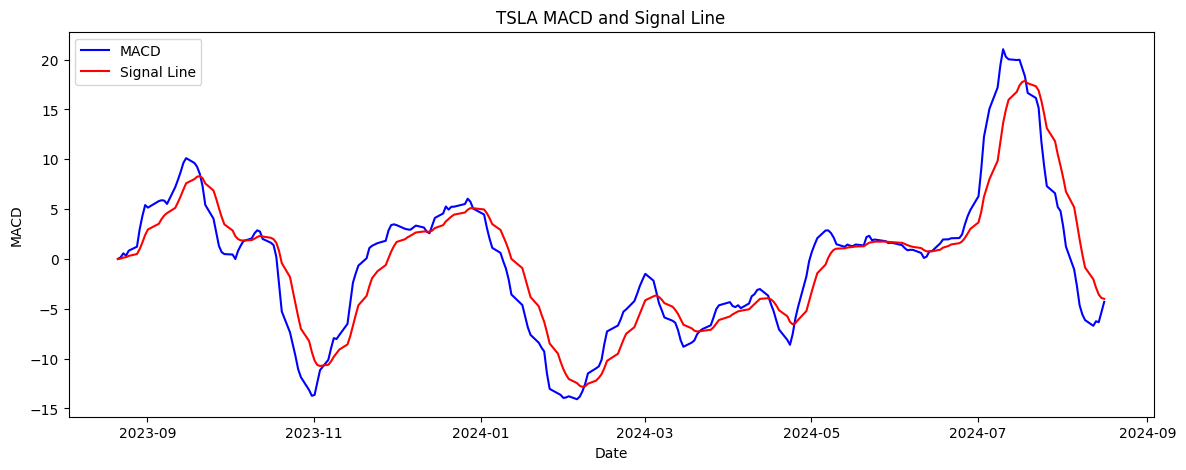

Total Return for TSLA: 0.48%
Failed to place stop-loss order: invalid stop_price 169.3636. sub-penny increment does not fulfill minimum pricing criteria
Bought 57.0 shares of TSLA at 172.82
Trading completed.


In [151]:
def run_strategy(symbols):
    start_date = datetime.now() - timedelta(days=365)
    end_date = datetime.now() - timedelta(days=1)

    for symbol in symbols:
        print(f"\nRunning strategy for {symbol}...\n")

        # Data Collection
        bars = collect_data(symbol, start_date, end_date)

        # Sentiment Analysis
        news_df = fetch_news_and_analyze_sentiment(symbol, start_date, end_date)

        # Technical Analysis and Signal Generation
        bars_indicators = calculate_technical_indicators_and_visualize(bars, symbol)
        bars_with_signals = generate_signals(bars_indicators)

        # Backtesting
        bars_with_sentiment, total_return = backtest_strategy(bars_with_signals)
        print(f"Total Return for {symbol}: {total_return:.2%}")

        # Trading Strategy Execution
        execute_trade(symbol, bars_with_signals, api)

# Example usage
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
run_strategy(symbols)



Running strategy for AAPL...



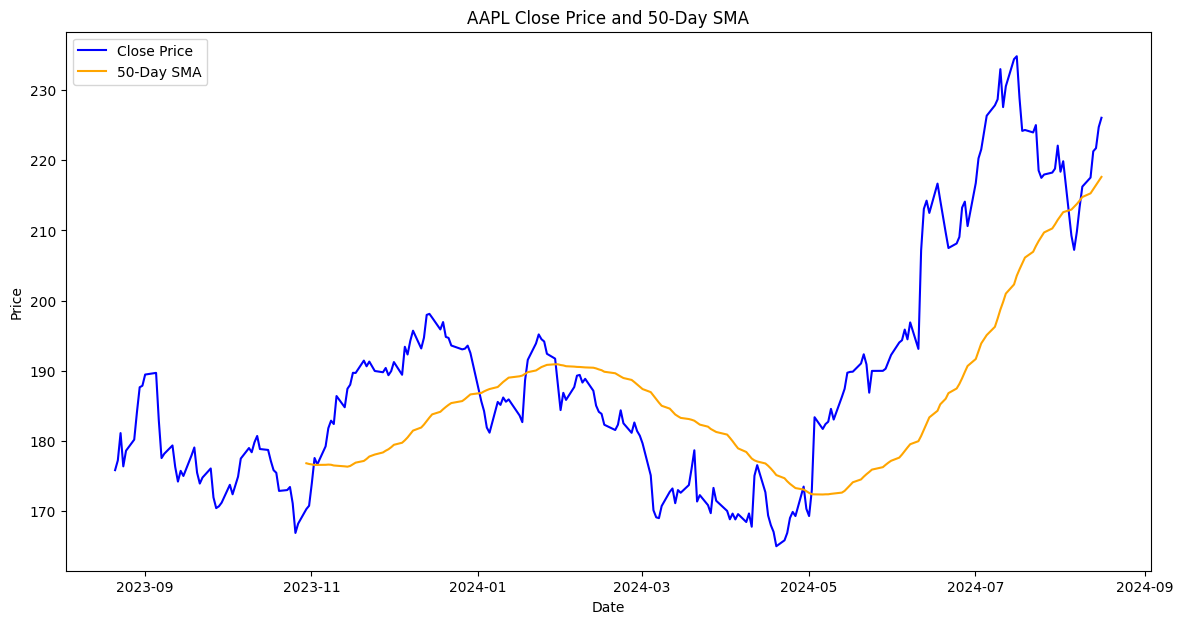

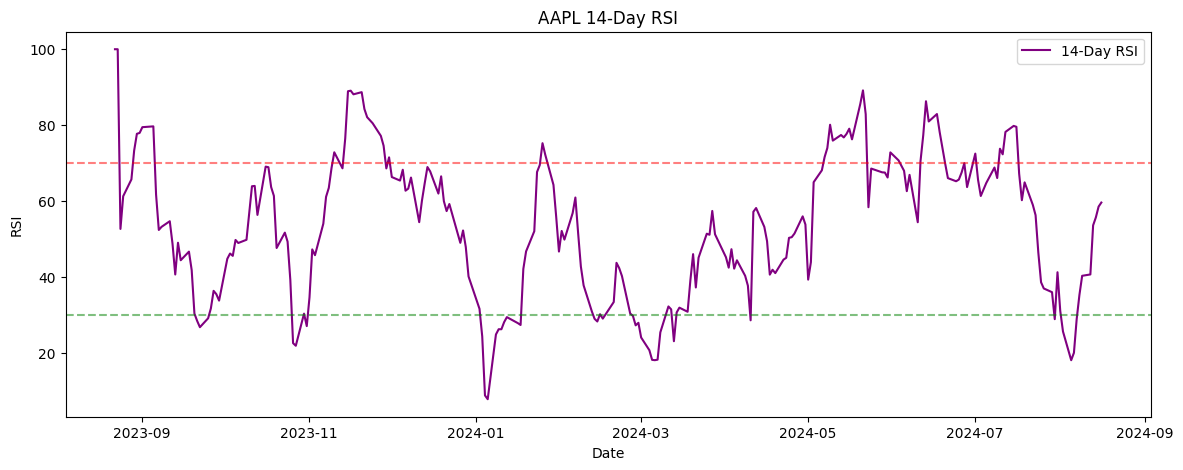

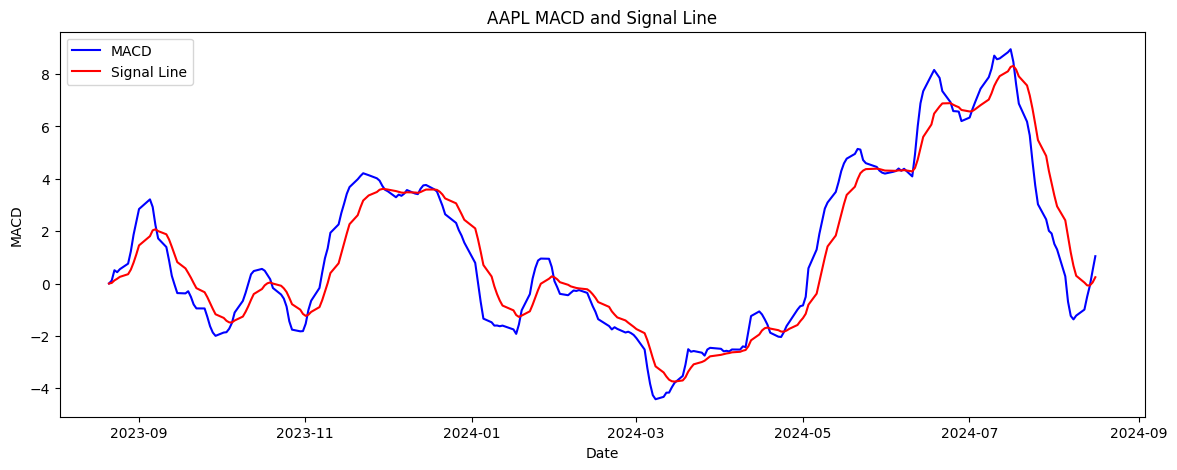

Current trade capital for AAPL: $-46234.27
Total Return for AAPL: 0.27%
Updated Capital for AAPL: $-46358.72
Insufficient capital to buy any shares of AAPL. Skipping trade.
Trading completed.

Running strategy for MSFT...



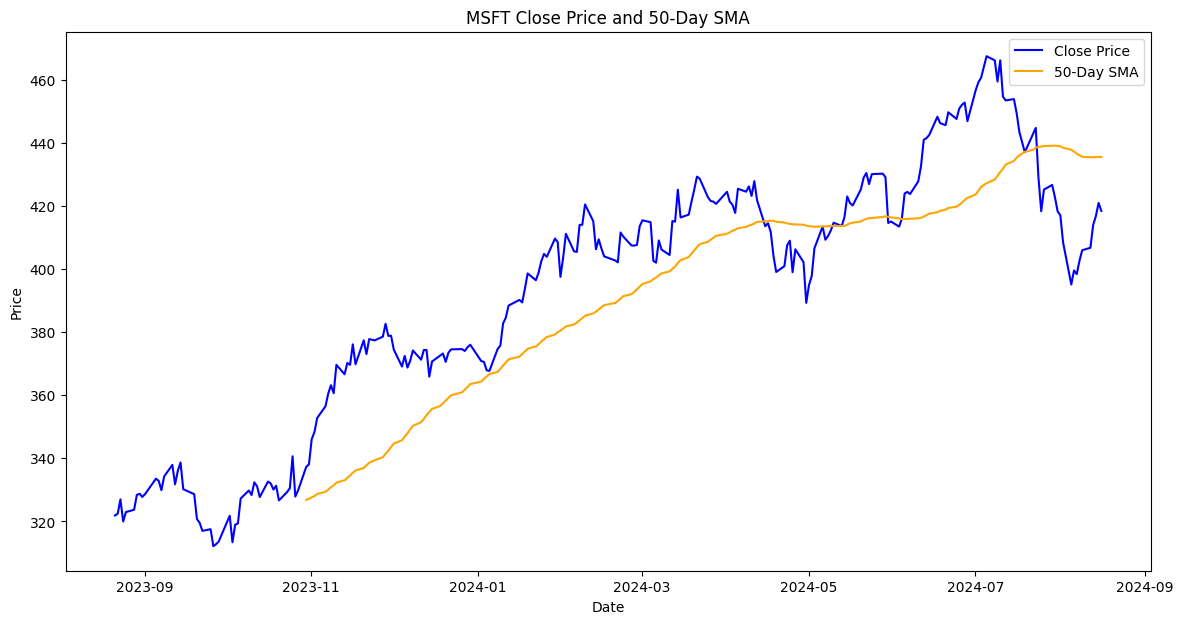

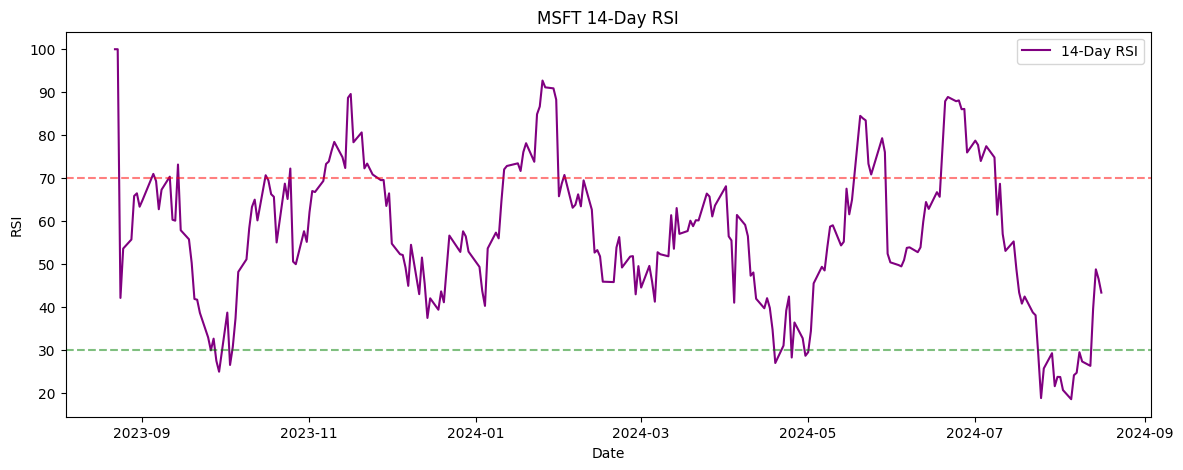

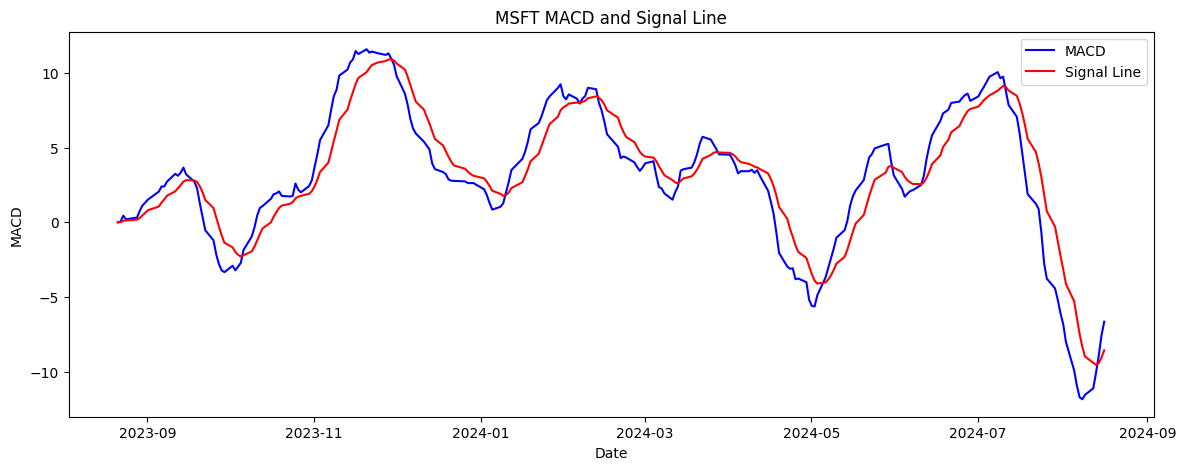

Current trade capital for MSFT: $-46234.27
Total Return for MSFT: 0.00%
Updated Capital for MSFT: $-46234.27
Strategy is no longer profitable for MSFT. Stopping trades.

Running strategy for GOOGL...



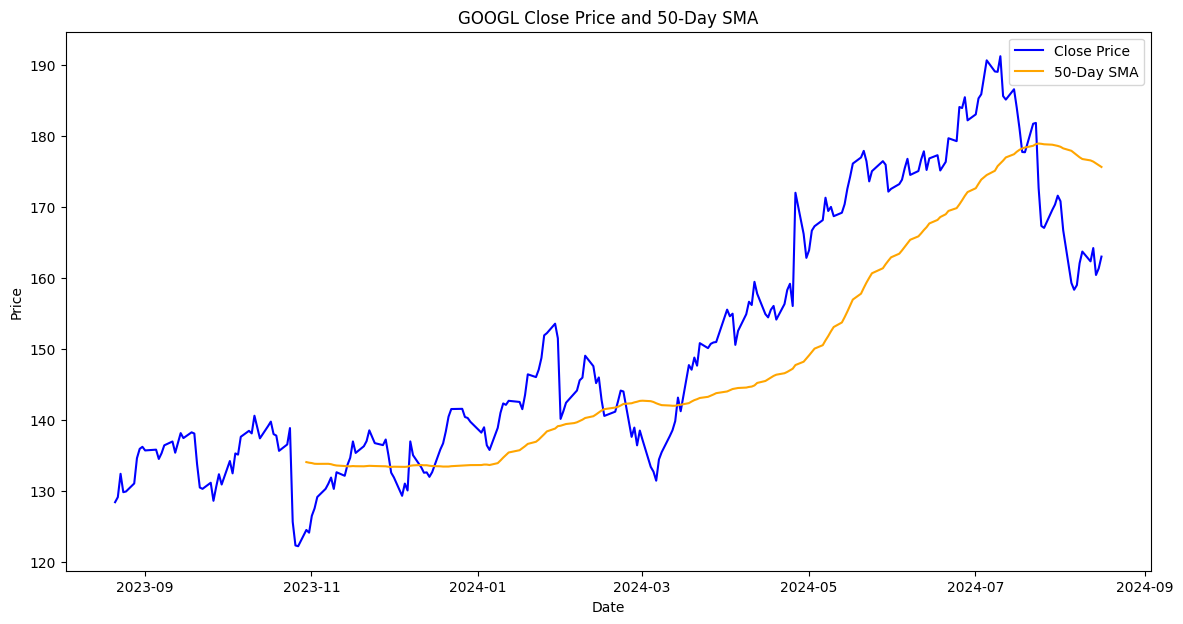

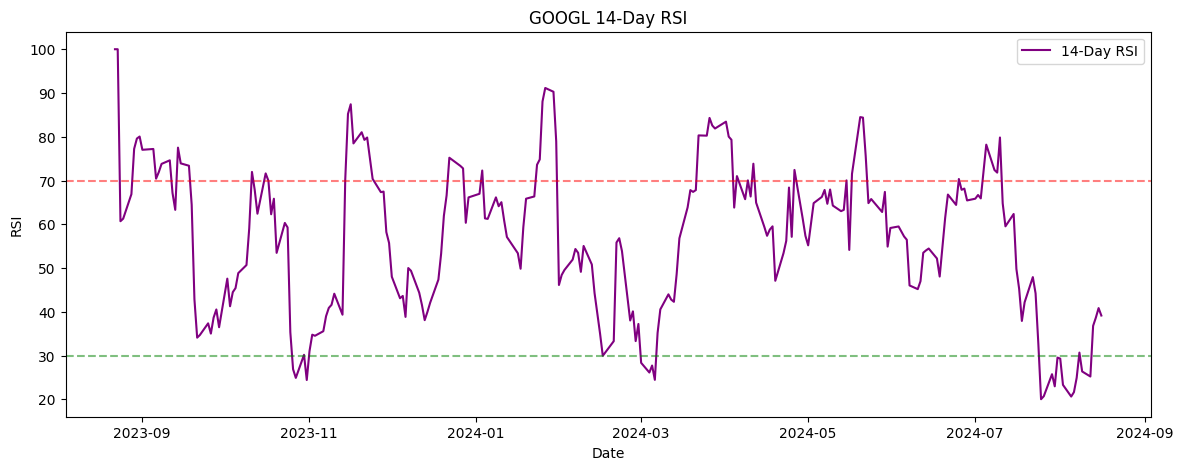

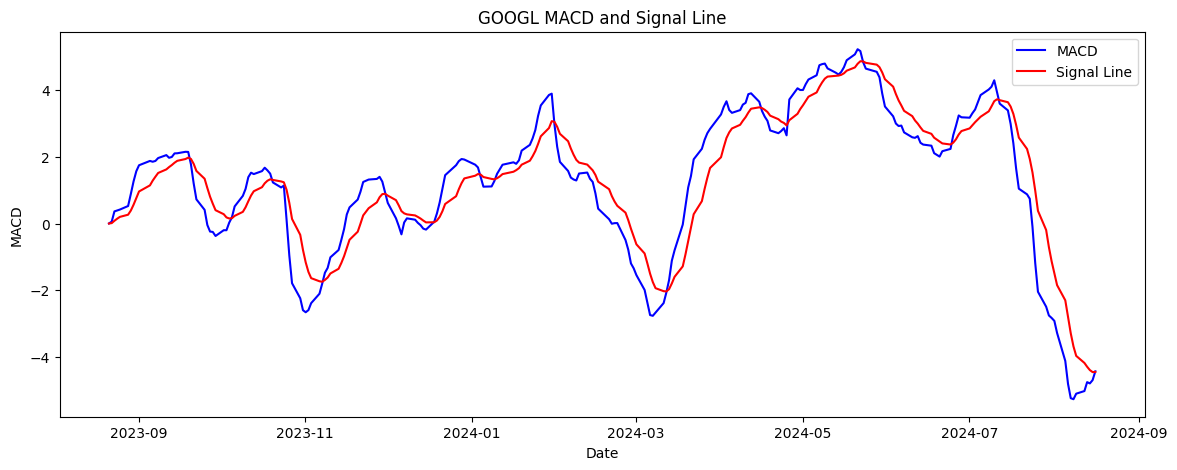

Current trade capital for GOOGL: $-46234.27
Total Return for GOOGL: 0.00%
Updated Capital for GOOGL: $-46234.27
Strategy is no longer profitable for GOOGL. Stopping trades.

Running strategy for AMZN...



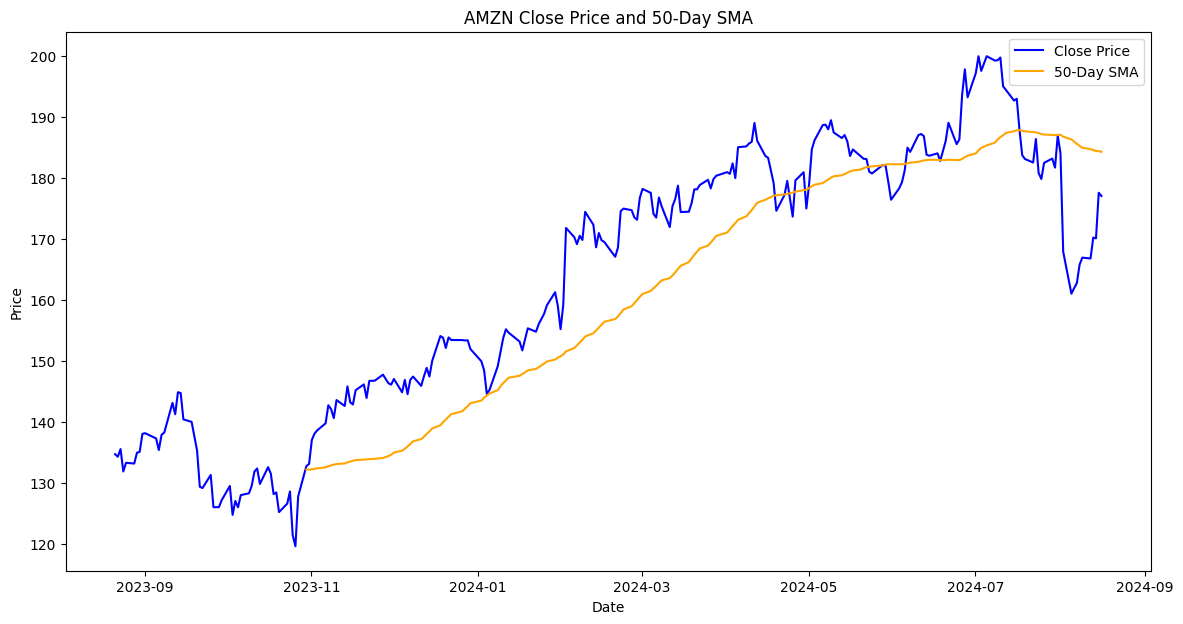

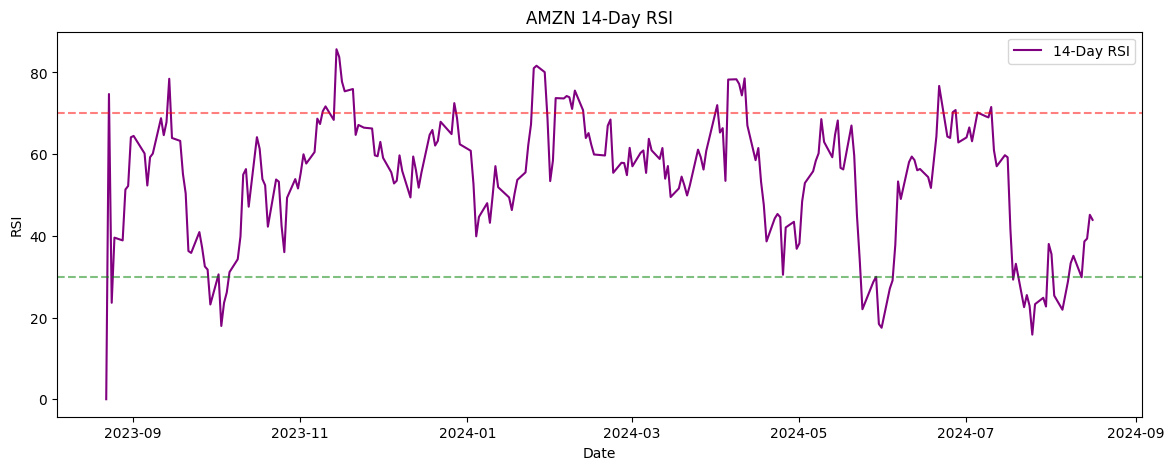

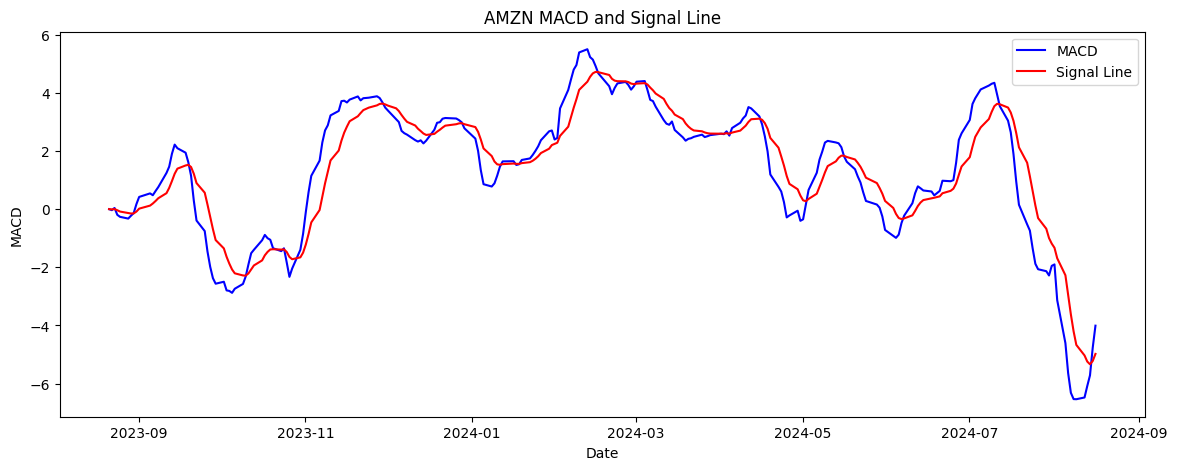

Current trade capital for AMZN: $-46234.27
Total Return for AMZN: 0.00%
Updated Capital for AMZN: $-46234.27
Strategy is no longer profitable for AMZN. Stopping trades.

Running strategy for TSLA...



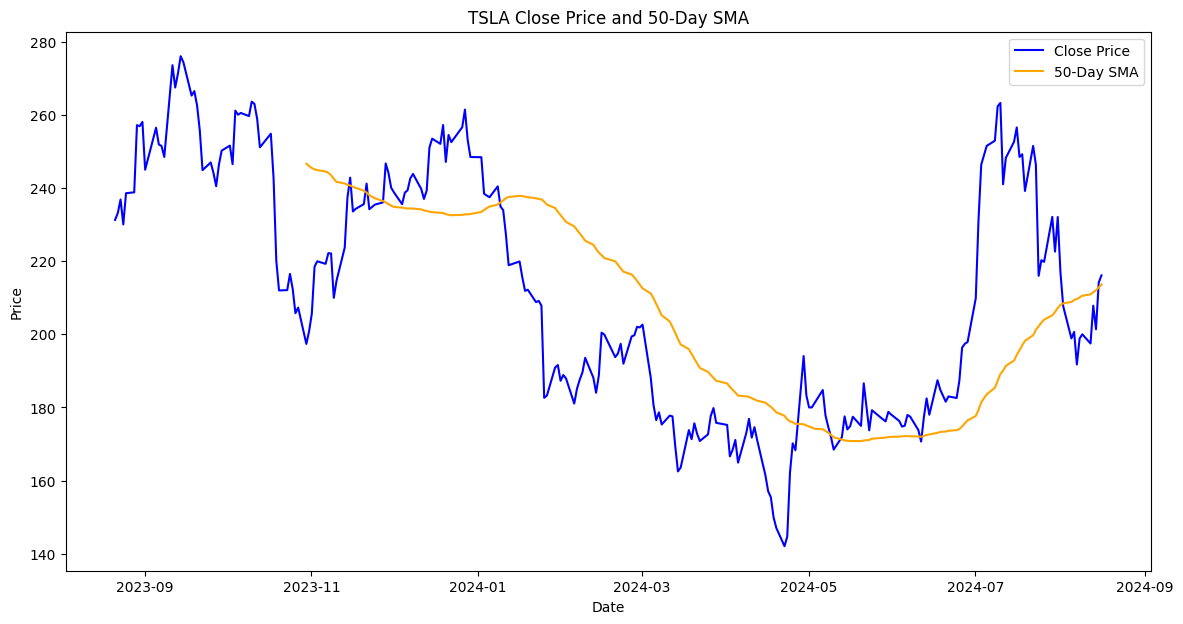

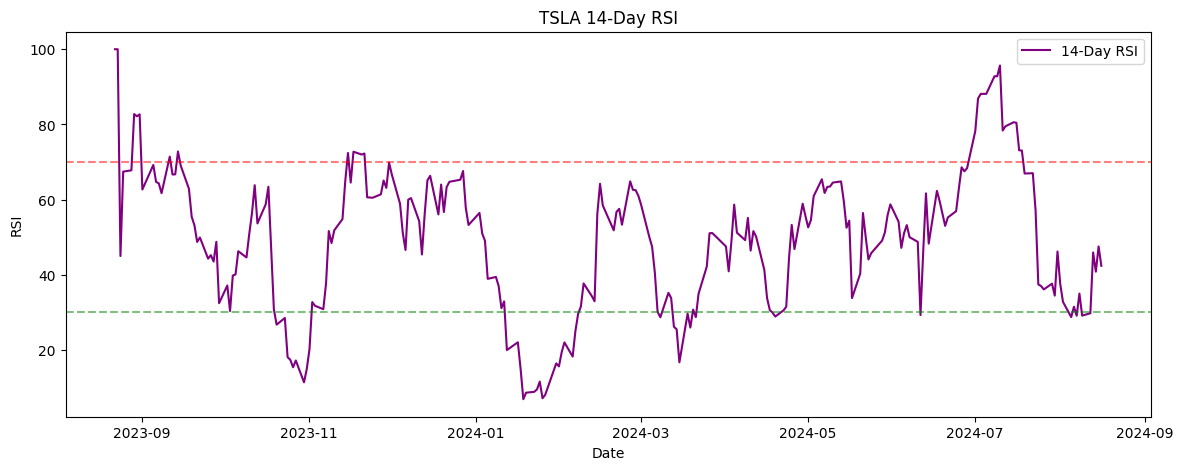

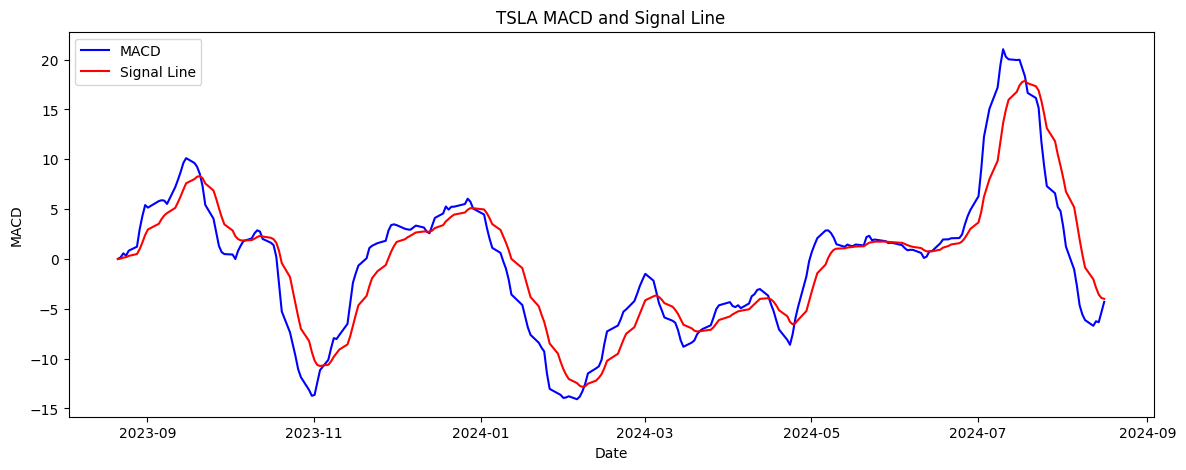

Current trade capital for TSLA: $-46234.27
Total Return for TSLA: 0.48%
Updated Capital for TSLA: $-46454.48
Insufficient capital to buy any shares of TSLA. Skipping trade.
Trading completed.
Strategy execution completed for all symbols.


In [28]:
import time
from datetime import datetime, timedelta


def run_strategy2(symbols, stop_loss_percentage=0.02, sleep_interval=3600):
    start_date = datetime.now() - timedelta(days=365)
    end_date = datetime.now() - timedelta(days=1)


    for symbol in symbols:
        print(f"\nRunning strategy for {symbol}...\n")

        # Data Collection
        bars = collect_data(symbol, start_date, end_date)

        # Sentiment Analysis
        news_df = fetch_news_and_analyze_sentiment(symbol, start_date, end_date)

        # Technical Analysis and Signal Generation
        bars_indicators = calculate_technical_indicators_and_visualize(bars, symbol)
        bars_with_signals = generate_signals(bars_indicators)

        profitable = True  # Flag to continue trading if profitable

        while profitable:
            # Extract current trade capital from Alpaca account
            account = api.get_account()
            trade_capital = float(account.cash)
            print(f"Current trade capital for {symbol}: ${trade_capital:.2f}")

            # Backtesting
            bars_with_sentiment, total_return = backtest_strategy(bars_with_signals)
            current_capital = trade_capital * (1 + total_return)
            print(f"Total Return for {symbol}: {total_return:.2%}")
            print(f"Updated Capital for {symbol}: ${current_capital:.2f}")

            if total_return > 0:
                # Execute trades based on generated signals
                execute_trade(symbol, bars_with_sentiment, api, trade_capital=current_capital, stop_loss_percentage=stop_loss_percentage)
            else:
                print(f"Strategy is no longer profitable for {symbol}. Stopping trades.")
            profitable = False  # Stop trading if the strategy is not profitable

            # Sleep for a defined interval before checking the market again
            time.sleep(30)

    print("Strategy execution completed for all symbols.")

# Example usage
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
run_strategy2(symbols)
